In [1]:
!pip install torch torchvision numpy matplotlib opencv-python tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:

!git clone https://github.com/hellowangqian/sganet-crowd-counting.git
%cd sganet-crowd-counting

Cloning into 'sganet-crowd-counting'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 34 (delta 13), reused 2 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 25.00 KiB | 3.57 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/sganet-crowd-counting


In [3]:
!unzip /content/crowd_wala_dataset.zip -d dataset


Archive:  /content/crowd_wala_dataset.zip
   creating: dataset/crowd_wala_dataset/
   creating: dataset/crowd_wala_dataset/test_data/
   creating: dataset/crowd_wala_dataset/test_data/ground_truth/
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_1.mat  
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_10.mat  
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_100.mat  
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_101.mat  
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_102.mat  
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_103.mat  
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_104.mat  
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_105.mat  
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_106.mat  
  inflating: dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_107.mat  
  inf

In [4]:
!apt-get update
!apt-get install -y libgl1-mesa-glx

import os
import numpy as np
import cv2
import scipy.io
from tqdm import tqdm

def generate_density_map(image_shape, points, sigma=15):
    h, w = image_shape
    density = np.zeros((h, w), dtype=np.float32)
    for point in points:
        x = min(w-1, max(0, int(round(point[0]))))
        y = min(h-1, max(0, int(round(point[1]))))
        density[y, x] += 1
    density = cv2.GaussianBlur(density, (0, 0), sigma)
    return density

def extract_points(mat):
    if 'annPoints' in mat:
        return mat['annPoints']
    elif 'image_info' in mat:
        points_raw = mat['image_info'][0,0][0,0][0]
        points = []
        for pt in points_raw:
            x = float(pt[0]) if isinstance(pt[0], (float, int)) else float(np.array(pt[0]).squeeze())
            y = float(pt[1]) if isinstance(pt[1], (float, int)) else float(np.array(pt[1]).squeeze())
            points.append([x, y])
        return np.array(points)
    else:
        print("Unknown keys in .mat file:", mat.keys())
        return None

for split in ['train_data', 'test_data']:
    img_dir = f'dataset/crowd_wala_dataset/{split}/images'
    gt_dir = f'dataset/crowd_wala_dataset/{split}/ground_truth'
    density_dir = f'dataset/crowd_wala_dataset/{split}/density_maps'
    os.makedirs(density_dir, exist_ok=True)
    if not os.path.exists(img_dir):
        print(f"Directory {img_dir} does not exist. Please check your dataset path.")
        continue
    for img_name in tqdm(os.listdir(img_dir)):
        if not img_name.endswith('.jpg'):
            continue
        img_path = os.path.join(img_dir, img_name)
        gt_path = os.path.join(gt_dir, 'GT_' + img_name.replace('.jpg', '.mat'))
        density_path = os.path.join(density_dir, img_name.replace('.jpg', '.npy'))
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        mat = scipy.io.loadmat(gt_path)
        points = extract_points(mat)
        if points is None or len(points) == 0:
            continue
        density = generate_density_map((h, w), points)
        np.save(density_path, density)


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,778 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,296 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-securit

100%|██████████| 316/316 [00:13<00:00, 24.04it/s]


In [5]:
import numpy as np
import os

density_dir = 'dataset/crowd_wala_dataset/train_data/density_maps'
density_files = [f for f in os.listdir(density_dir) if f.endswith('.npy')][:5]

for file in density_files:
    path = os.path.join(density_dir, file)
    density_map = np.load(path)
    print(f"{file}: sum={density_map.sum()}, min={density_map.min()}, max={density_map.max()}")


IMG_132.npy: sum=118.7444076538086, min=0.0, max=0.00436761137098074
IMG_53.npy: sum=125.52162170410156, min=0.0, max=0.0064279320649802685
IMG_135.npy: sum=42.03870391845703, min=0.0, max=0.0016419702442362905
IMG_188.npy: sum=345.1567077636719, min=0.0, max=0.009471231140196323
IMG_234.npy: sum=54.2877197265625, min=0.0, max=0.002989410189911723


In [ ]:
   import numpy as np

   data = np.load('/content/sganet-crowd-counting/dataset/crowd_wala_dataset/test_data/density_maps/IMG_1.npy')

   print(data)

   print(data.shape)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.6994088e-05
  9.5869334e-05 9.5492549e-05]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.7640317e-05
  9.6508076e-05 9.6128773e-05]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.9574201e-05
  9.8419536e-05 9.8032724e-05]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
(768, 1024)


In [5]:
!pip install torch torchvision scikit-image

import os
import cv2
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.measure import block_reduce

In [6]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class CrowdDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(256,256), density_size=(64,64)):
        self.img_dir = os.path.join(root_dir, 'images')
        self.density_dir = os.path.join(root_dir, 'density_maps')
        self.gt_dir = os.path.join(root_dir, 'ground_truth')
        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith('.jpg')])
        self.transform = transform
        self.target_size = target_size
        self.density_size = density_size

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_filename = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        density_path = os.path.join(self.density_dir, img_filename.replace('.jpg', '.npy'))
        gt_filename = 'GT_' + img_filename.replace('.jpg', '.mat')
        gt_path = os.path.join(self.gt_dir, gt_filename)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.target_size[1], self.target_size[0]))  # (width, height)

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img.transpose((2, 0, 1))).float() / 255.0

        density = np.load(density_path)
        original_sum = density.sum()
        density = cv2.resize(density, (self.density_size[1], self.density_size[0]), interpolation=cv2.INTER_CUBIC)
        if density.sum() > 0 and original_sum > 0:
           density = density * (original_sum / density.sum())
        density = torch.from_numpy(density).unsqueeze(0).float()



        return img, density, gt_filename, gt_path


In [7]:
train_dir = 'dataset/crowd_wala_dataset/train_data'
test_dir = 'dataset/crowd_wala_dataset/test_data'

train_dataset = CrowdDataset(train_dir, target_size=(256, 256), density_size=(64, 64))
test_dataset = CrowdDataset(test_dir, target_size=(256, 256), density_size=(64, 64))

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


In [9]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from myInception_segLoss import headCount_inceptionv3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = headCount_inceptionv3(pretrained=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
criterion = nn.MSELoss()

def train_model(model, dataloader, optimizer, scheduler, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, targets, _, _ in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            #print("Output min:", outputs.min().item(), "max:", outputs.max().item())
            #print("Target min:", targets.min().item(), "max:", targets.max().item())


            #print("Model output shape:", outputs.shape)
            #print("Target shape:", targets.shape)
            loss = criterion(outputs, targets.squeeze(1))

            #loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.8f}')

def test_model(model, dataloader):
    model.eval()
    mae = 0.0
    with torch.no_grad():
        for images, targets, _, _ in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            outputs, _ = model(images)
            pred_count = outputs.sum().item()
            true_count = targets.sum().item()
            mae += abs(pred_count - true_count)
    mae /= len(dataloader)
    print(f'Test MAE: {mae:.4f}')

num_epochs = 100
train_model(model, train_loader, optimizer, scheduler, num_epochs)
test_model(model, test_loader)


Epoch 1/100, Loss: 0.07369896
Epoch 2/100, Loss: 0.01170428
Epoch 3/100, Loss: 0.01105613
Epoch 4/100, Loss: 0.01073557
Epoch 5/100, Loss: 0.00952449
Epoch 6/100, Loss: 0.00766103
Epoch 7/100, Loss: 0.00668476
Epoch 8/100, Loss: 0.00701748
Epoch 9/100, Loss: 0.00581742
Epoch 10/100, Loss: 0.00502535
Epoch 11/100, Loss: 0.00534688
Epoch 12/100, Loss: 0.00529780
Epoch 13/100, Loss: 0.00359776
Epoch 14/100, Loss: 0.00404752
Epoch 15/100, Loss: 0.00392553
Epoch 16/100, Loss: 0.00366348
Epoch 17/100, Loss: 0.00303118
Epoch 18/100, Loss: 0.00294555
Epoch 19/100, Loss: 0.00250251
Epoch 20/100, Loss: 0.00308305
Epoch 21/100, Loss: 0.00233929
Epoch 22/100, Loss: 0.00232914
Epoch 23/100, Loss: 0.00250045
Epoch 24/100, Loss: 0.00261731
Epoch 25/100, Loss: 0.00274854
Epoch 26/100, Loss: 0.00209718
Epoch 27/100, Loss: 0.00225384
Epoch 28/100, Loss: 0.00237473
Epoch 29/100, Loss: 0.00183046
Epoch 30/100, Loss: 0.00159183
Epoch 31/100, Loss: 0.00152449
Epoch 32/100, Loss: 0.00151353
Epoch 33/100, Los

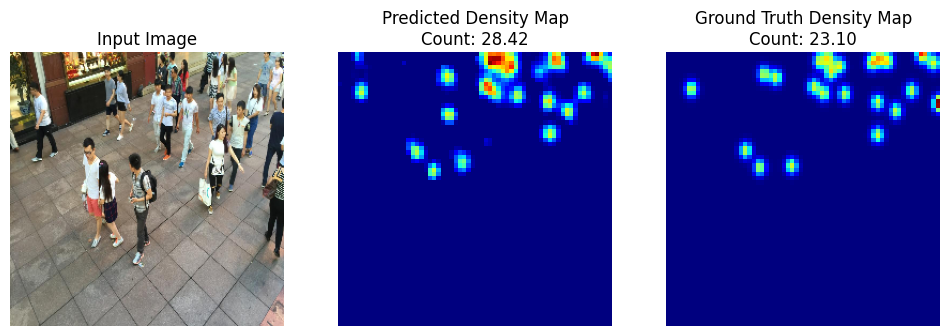

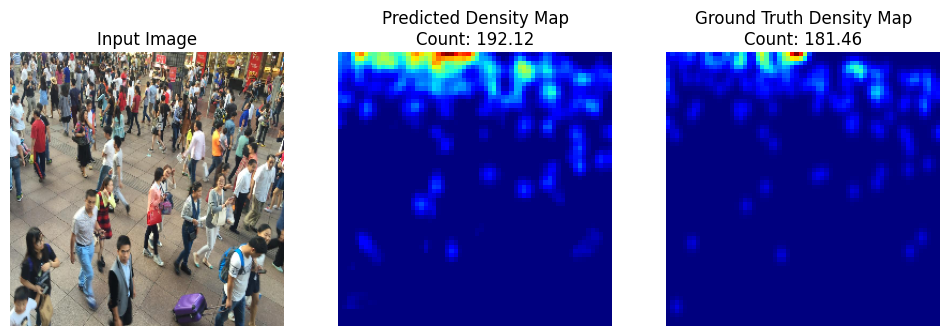

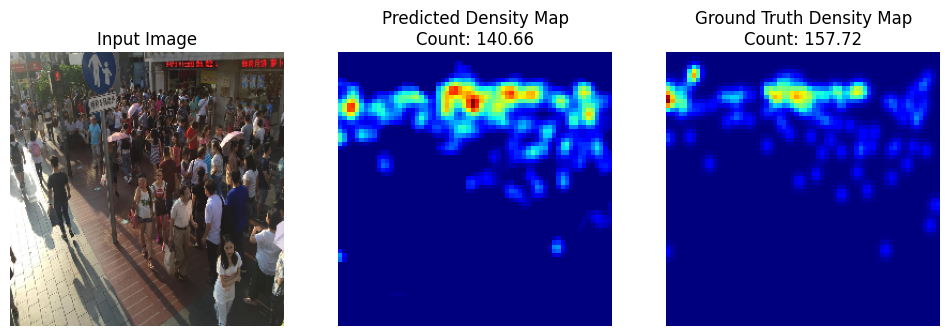

In [10]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for images, targets, _, _ in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            outputs, _ = model(images)
            if outputs.dim() == 3:
                outputs = outputs.unsqueeze(1)

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                img = images[i].cpu().permute(1, 2, 0).numpy()
                pred_density = outputs[i].cpu().squeeze().numpy()
                gt_density = targets[i].cpu().squeeze().numpy()

                pred_count = pred_density.sum()
                gt_count = gt_density.sum()

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(img)
                plt.title('Input Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(pred_density, cmap='jet')
                plt.title(f'Predicted Density Map\nCount: {pred_count:.2f}')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(gt_density, cmap='jet')
                plt.title(f'Ground Truth Density Map\nCount: {gt_count:.2f}')
                plt.axis('off')

                plt.show()
                samples_shown += 1

visualize_predictions(model, test_loader, device, num_samples=3)
